# **Table of contents**

Introduction

1.   Importing Libraries

2.   Data Gathering

  *   SQL Request

3.   List of cleaning functions
2.   Cleaning pipelines

5.   Cleaned Data

   *   data: inluding all word positions
   *   data_nouns: keeping only nouns in texts

6.   Analysing the data

   *   unique words
   *   most frequent word













# **Introduction**

- In this study, we will offer a textual analysis of the questions asked on the stackoverflows site.

-  Our ultimate goal is to offer automatic tagging of questions to help beginners in their first steps on the site.

## **Importing Libraries** 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import string
import re 
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger
from nltk.tag import pos_tag
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## **Data Gathering**

### SQL Request

In [ ]:
#here the SQL Request we used
'''
SELECT * FROM posts
WHERE Title is not null and Title <> '' AND
      Tags is not null and Tags <> '' AND 
      CreationDate>=  '2020-04-01' AND CreationDate < '2021-04-01' AND 
      Body LIKE '%<code>%' AND
      Score>1 AND AnswerCount>1 AND
      FavoriteCount>0 AND ViewCount>10
      '''

We did filter the data regarding:

- **Title** & **Tags**: No empty Titles or Tags
- **CreationDate**: one year of data
- **Body_script**: Question with the *code* included
- **Score** & **AnswerCount**: we chose questions with high ratings and more than one answer 
- **N_views** & **Favorite_Count**: most viewed questions and the ones judged the best 

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/QueryResults.csv',index_col=0)

In [ ]:
data=data.sample(10000)

In [ ]:
data['Body'].sample(10)

Id
61041282    <p>I have a small WPF application which has a ...
63357120    <p>I have an issue while deploying my Spring b...
61624066    <p>I have a Snakemake workflow that I've been ...
61616810    <p>In Pytorch, is there cubic spline interpola...
61195550    <p>I remember reading somewhere that a type li...
62667045    <p>I would like to do the exact same thing as ...
62856487    <p>I'm using Application Insights in ASP.NET C...
62951440    <p>I have a simple <code>select</code> which n...
65514207    <p>Small question on an issue reported by Sona...
63343774    <p>I am new in flutter just want to know using...
Name: Body, dtype: object

In [ ]:
data['Tags'].loc[61195550]

'<haskell><traversable>'

In [ ]:
body_pipeline(data['Body'].loc[61195550])

'remember reading somewhere type like one bit explanation remember hold instance visit element lawful instance however remember lawful instance one look fine first glance unlawful'

In [ ]:
code_pipeline(data['Body'].loc[61195550])

'traversabledata bar bar deriving show  instance functor bar where fmap bar bar x  instance foldable bar where foldmap bar f lt  gt x foldmap   foldmapdefaulttraversableinstance traversable bar where sequencea  bar bar  lt lt   gt  x'

In [ ]:
clean_tags(data['Tags'].loc[61195550])

'haskell traversable'

##List of cleaning functions

In [ ]:
def get_code(input):
  ind=input.index('<code>')
  res=''
  while '<code>' in input[ind:]:
    end=input.index('</code>',ind)
    res=res+input[ind+6:end]
    ind=input.find('<code>',end)
  return res.lower()

def substitute_code(input):
  ind=input.index('<code>')
  while '<code>' in input[ind:]:
    end=input.index('</code>')
    input=input.replace(input[ind:end+7],' ')
    ind=input.find('<code>')
  return input.lower()


from bs4 import BeautifulSoup
def remove_html_tags(input):
  soup=BeautifulSoup(input,'html.parser')
  return soup.get_text(' ')


def remove_punctuation(input):

  lang_dict={'c#':'csharp',
             'C#':'csharp',
             'c#-4.0':'csharp',

             'Go':'goLang',
             'go':'goLang',

             'VB':'VisualBasic',
             'vb':'VisualBasic',
             'Vb':'VisualBasic',
             'VB.net':'VisualBasic',

             'd3.js':'d3js',
             'd3\.js':'d3js',
             'nvd3.js':'d3js',

             'g++5.1':'gplusplus',
             'g++4.8':'gplusplus',
             'g++':'gplusplus',
             'gcc4.8':'gplusplus',
             'gcc':'gplusplus',
             'gcc10':'gplusplus',
             'g++10':'gplusplus',

             'c++':'cplusplus',
             'C++':'cplusplus',
             'c++14':'cplusplus',
             'C++14':'cplusplus',
             'c++17':'cplusplus',
             'C++17':'cplusplus',
             'c++98':'cplusplus',
             'C++98':'cplusplus',
             'c++11':'cplusplus',
             'C++11':'cplusplus',
             'c++20':'cplusplus',
             'C++20':'cplusplus',
             'clang++':'cplusplus',
             'libstdc++':'cplusplus',
             'libs++':'cplusplus',

             'c':'clang',
             'C':'clang',

             'qt':'Qt_framework',
             'qt4':'Qt_framework',
             'qt5':'Qt_framework',
             'qt-creator':'Qt_framework',
             'pyqt':'Qt_framework',

             'vue.js':'vuejs',
             'vuejs2':'vuejs',
             'vue-component':'vuejs',
             'vuex':'vuejs',
             'vuetify.js':'vuejs',
             'vue-router':'vuejs',

             'r':'rLang',
             'R':'rLang',

             '.net':'dotnet',
             
             'io':'input_output',
             
             'js':'javascript',
             
             'vs':'VisualStudio'}
  
  word_list=[]
  for word in input.split():
    if word in list(lang_dict.keys()):
      word_list.append(lang_dict[word])
    else:
      word_list.append(word)
  
  input=' '.join(token for token in word_list)
  #punctuation
  input=re.sub(pattern=r'\w*\d\w*',repl='', string=input).strip() #Remove digits and word associated with digits
  input=re.sub(pattern='\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b',repl='',string=str(input))#removing words like 'zzz', 'testtting', 'grrrrrrreet. words with consecutive three repeating characters
  input=re.sub(pattern='[^\w]',repl=' ',string=input) #Remove special characters
  input=re.sub(pattern=r'\s+[a-zA-Z]\s+',repl=' ',string=input) #Remove all single characters
  input=re.sub(pattern=r'\^[a-zA-Z]\s+',repl= ' ', string=input)#Remove single characters from the start
  
  return input



from nltk.corpus import stopwords
def remove_stopwords(input):

  stop_words=stopwords.words('english')
  #The custom Stopwords list, was built with the top 100 common words in titles and body after running a counter method to check for word occurences
  stop_words.extend(['how','why','is','what','use','can','keep','get','do','want','give','read',
                     'leave','code','consider','program','difference','solution','modify','way',
                     'choose','miss','change','search','implement','install','select','would',
                     'could','none','retrieve','find','copy','explain','handle','count','help',
                     'please','react','create','work','run','add','code','name','without','call',
                     'make','new','update','remove','another','test','check','access','show','select','need'])
  
  return ' '.join(word for word in word_tokenize(input) if word not in stop_words)
  

def lemmatize(input,only_nouns=False):

  #main idea behind ''only_nouns'' argument, is to simplify the input with keeping only nouns for topic modeling 


  wnl=WordNetLemmatizer()
  word_lemmatized=[]
  for word,tag in pos_tag(word_tokenize(input)):

    if len(word)<=3:
      word_lemmatized.append(word)
    else:
      if not only_nouns:
        if tag.startswith('N'):
          word_lemmatized.append(wnl.lemmatize(word,pos='n'))
        elif tag.startswith('V'):
          word_lemmatized.append(wnl.lemmatize(word,pos='v'))
        elif tag.startswith('J'):
          word_lemmatized.append(wnl.lemmatize(word,pos='a'))
        elif tag.startswith('R'):
          word_lemmatized.append(wnl.lemmatize(word,pos='r'))
        else:
          word_lemmatized.append(wnl.lemmatize(word,pos='n'))
      else:
        if tag.startswith('N'):
          word_lemmatized.append(wnl.lemmatize(word,pos='n'))    

  return ' '.join(x for x in word_lemmatized)

def stemming(input):
  
  stem=SnowballStemmer('english', ignore_stopwords=True)

  return ' '.join(stem.stem(word) for word in word_tokenize(input))


## Cleaning Pipelines

In [ ]:
def body_pipeline(input,only_nouns=False):

  #clean_text
  input=remove_punctuation(remove_html_tags(substitute_code(input)))
  #text_mining
  if not only_nouns:
    input=lemmatize(remove_stopwords(input),only_nouns=False)
  else:
    input=lemmatize(remove_stopwords(input),only_nouns=True)

  return input


def code_pipeline(input):
  
  #extract_code
  input=get_code(input)
  #clean_code
  return remove_punctuation(input)


def title_pipeline(input,only_nouns=False):
  #clean_text
  input=remove_punctuation(input.lower())
  #text_mining
  if not only_nouns:
    input=lemmatize(remove_stopwords(input),only_nouns=False)
  else: 
    input=lemmatize(remove_stopwords(input),only_nouns=True)

  return input

def clean_tags(tags):

  tags=tags.replace('>',' ')
  tags=tags.replace('<',' ')
  tags=remove_punctuation(tags)
  unique = []
  for tag in word_tokenize(tags):
    if tag not in unique:
        unique.append(tag)

  return ' '.join(word for word in unique) 



## Cleaned Data

### **Data**: including all word positions

In this data we are going to include all the word positions (ADV,ADJ,VERB,NOUN)

In [ ]:
data['code']=data['Body'].apply(code_pipeline)
data['Title']=data['Title'].apply(lambda x: title_pipeline(x,only_nouns=False))
data['Tags']=data['Tags'].apply(clean_tags)
data['Body']=data['Body'].apply(lambda x: body_pipeline(x,only_nouns=False))

In [ ]:
data=data[['Title','Body','code','Tags']]

In [ ]:
data.to_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data.csv',index=False)

### **Data_nouns**: keeping only **nouns** in texts

We are doing the same, but keeping only the nouns this time 

In [ ]:
data['code']=data['Body'].apply(code_pipeline)
data['Title']=data['Title'].apply(lambda x: title_pipeline(x,only_nouns=True))
data['Tags']=data['Tags'].apply(clean_tags)
data['Body']=data['Body'].apply(lambda x: body_pipeline(x,only_nouns=True))

In [ ]:
data_nouns=data[['Title','Body','code','Tags']]

In [ ]:
data_nouns.to_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data_nouns.csv',index=False)

## Analysing the data

####Number of unique words in the title corpus 

In [ ]:
words=[]
for sent in data['Title'].values.tolist():
  for word in sent:
    words.append(word)
len(set(words))

111

#### get most frequent word

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Formation_Machine_Learning/P_NLP/data/data.csv')

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.head()

,Title,Body,Code,Tags
0,export default import vue find vue,beginner vuejs first app save nothing appear b...,import bootstrapvue from bootstrap vue i...,vuejs
1,iterate two list parallel kotlin,iterate two list kotlin assign value one list ...,textviewdata class total val area double pr...,list kotlin
2,directory contain directory,currently exclude directory contain sub direct...,find type a sub b sub sub dub sub bub fin...,bash find
3,faster element roll permutation swap two list,two list like take combination two list place ...,x a c original lists y b a c we...,python list algorithm
4,wait open txt file notepad cplusplus,open txt file notepad continue close notepad c...,string string topicname c hello hi hi txt ...,cplusplus windows


In [ ]:
from collections import Counter

In [ ]:
count=Counter()

In [ ]:
from collections import defaultdict
total = 0
count = defaultdict(lambda: 0)
for line in words:
  for word in line:
    total += 1
    count[word] += 1

In [ ]:
count['key']

147

In [ ]:
from collections import Counter,defaultdict
count=Counter()
lines=data['Title'].values.tolist()
for sentence in lines:
  count.update(word for word in word_tokenize(sentence))
most_common=np.array(count.most_common())

In [ ]:
most_common.shape

(14387, 2)

**plot 20 most common words in the counter for the titles**

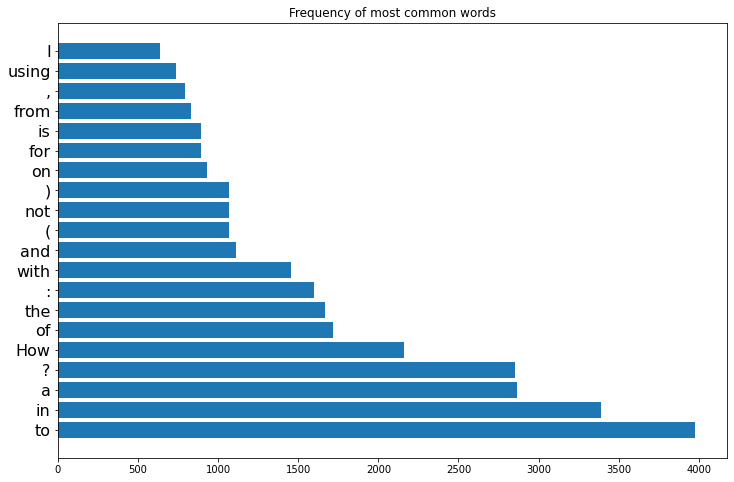

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))    
plt.barh(range(0,20), width=most_common[:20,1].astype(int))

ax.set_yticks(range(0,20))
ax.set_yticklabels(most_common[:20, 0], minor=False,fontdict={'fontsize':16})
plt.title('Frequency of most common words')
plt.show()

In [ ]:
np.array(count.most_common())[:100,0]

array(['use', 'value', 'error', 'function', 'python', 'column', 'list',
       'file', 'array', 'type', 'data', 'string', 'java', 'multiple',
       'object', 'class', 'app', 'row', 'flutter', 'android', 'return',
       'two', 'one', 'dataframe', 'rLang', 'element', 'variable',
       'javascript', 'set', 'base', 'number', 'time', 'fail', 'work',
       'docker', 'different', 'image', 'panda', 'method', 'api', 'find',
       'convert', 'group', 'angular', 'key', 'parameter', 'build',
       'table', 'text', 'swiftui', 'module', 'map', 'component',
       'cplusplus', 'inside', 'loop', 'google', 'line', 'spring',
       'version', 'package', 'server', 'js', 'user', 'property', 'custom',
       'json', 'ios', 'import', 'match', 'typescript', 'request', 'index',
       'std', 'get', 'page', 'load', 'css', 'VisualStudio', 'result',
       'filter', 'specific', 'issue', 'core', 'date', 'unable',
       'template', 'firebase', 'git', 'possible', 'window', 'argument',
       'field', 'call',

In [ ]:
most_common_words=sorted_items[:100,0]

In [ ]:
most_common_words

[('use', 1241),
 ('value', 886),
 ('error', 841),
 ('function', 762),
 ('python', 694),
 ('column', 624),
 ('list', 624),
 ('file', 610),
 ('array', 599),
 ('type', 555),
 ('data', 527),
 ('string', 508),
 ('java', 423),
 ('multiple', 418),
 ('object', 417),
 ('class', 371),
 ('app', 352),
 ('row', 348),
 ('flutter', 325),
 ('android', 310),
 ('return', 298),
 ('two', 289),
 ('one', 288),
 ('dataframe', 288),
 ('rLang', 288),
 ('element', 287),
 ('variable', 286),
 ('javascript', 283),
 ('set', 280),
 ('base', 279),
 ('number', 278),
 ('time', 267),
 ('fail', 261),
 ('work', 255),
 ('docker', 253),
 ('different', 251),
 ('image', 243),
 ('panda', 239),
 ('method', 234),
 ('api', 231),
 ('find', 222),
 ('convert', 211),
 ('group', 211),
 ('angular', 210),
 ('key', 205),
 ('parameter', 201),
 ('build', 201),
 ('table', 200),
 ('text', 199),
 ('swiftui', 196),
 ('module', 189),
 ('map', 187),
 ('component', 184),
 ('cplusplus', 182),
 ('inside', 181),
 ('loop', 180),
 ('google', 176),
 ('

In [ ]:
data.groupby('Tags')['Title'].count().sort_values(ascending=False).head(10)

Tags
 python  pandas                98
 python                        87
 javascript                    86
 python  pandas  dataframe     64
 c++                           57
 r  dplyr                      56
 r                             54
 html  css                     46
 flutter  dart                 32
 java                          30
Name: Title, dtype: int64